In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import nnls
from scipy.sparse.linalg import lsqr
from scipy.linalg import pinv, svd
from math import cos, sin

plt.style.use('stylesheet.mplstyle')

# parameters
freq = 1 # Hz
c = 1000 # m/s
lam = c / freq # m
amplitude=1
Nsensors = 30

# signal direction
phi = np.pi/2# np.random.rand(1e5) * 2 * np.pi # rad
# phis_to_inject = np.random.rand(1e5) * 2 * np.pi # rad
direction_vector = [cos(phi), sin(phi)] # vector in cartesian coordinates

# station sampling information
sample_rate = 10 # sample rate [Hz]
duration = 10 # seconds
Nsamples = sample_rate * duration # number of samples
times = np.arange(Nsamples) / sample_rate # times

# random
num_phis_for_search = 360

# Array processing from the start

We do some array processing using similar least squares methods, but for a scalar wave traveling across the array. If you want to run this full notebook you'll need to install a few more packages: `dynesty` and `corner`.

Let's consider some wave traveling through our array. We'll give it these properties

| parameter | variable | value | 
| - | - | - | 
| Frequency [Hz] | $f$  | 1 | 
| Velocity | $c$ | 1000 | 

We'll also consider an array of 100 randomly placed stations in the x-y plane where the x and y values are chosen from uniform distributions between 0 and 5$\lambda$ where $\lambda$ is the wavelength of the wave traveling through the array.

We'll do this with no noise for now.

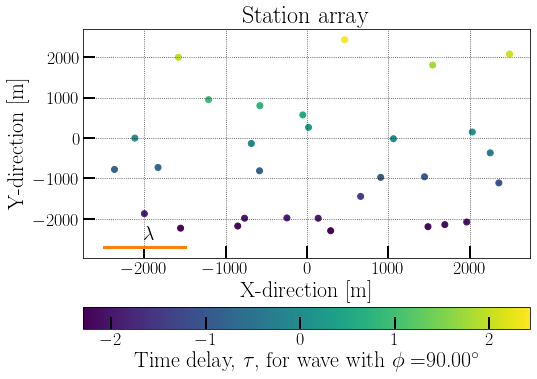

In [2]:
# set up station locations
Xs = np.random.rand(Nsensors) * lam * 5 - lam*2.5
Ys = np.random.rand(Nsensors) * lam * 5 - lam*2.5
locations = np.vstack((Xs, Ys)).T

# get time delays for wave with chosen direction
time_delays = np.dot(locations, direction_vector) / c

# plot
plt.figure(figsize=(8,6))
plt.scatter(Xs, Ys, c=time_delays)
h = plt.colorbar(orientation='horizontal') # time delays
h.ax.set_xlabel(r'Time delay, $\tau$, for wave with $\phi=$%4.2f$^\circ$' % np.degrees(phi))
plt.plot([-2.5*lam, -1.5*lam], [-2.7*lam, -2.7*lam], c='C1') # give wavelength as scale
ax = plt.gca()
ax.text(-2*lam, -2.5*lam, '$\lambda$', fontsize=20) 
plt.xlabel('X-direction [m]')
plt.ylabel('Y-direction [m]')
plt.title('Station array')
plt.show()


# Generate fake data

Ok, we now need to generate fake data for each of our stations. We'll start by generating some generic sinusoidal wave, shifting the phase based on the location of the sensor

In [3]:
data = np.zeros((Nsensors, Nsamples), dtype='complex')

for ii in range(Nsensors):
    phase = 2 * np.pi * freq * time_delays[ii]
    data[ii, :] = amplitude * np.exp(2 * np.pi * 1j * freq * times + 1j * phase)

# Data Analysis

Our method here is going to be to cross-correlate (in the frequency domain) each of our sensors. In this context, if we cross-correlate any two sensors with data $d_1(f) = s_1(f) + n_1(f)$ and $d_2(f) = s_2(f) + n_2(f)$, we find that

$$ d_1(f) d_2^*(f) = |s(f)|^2 e^{2\pi i f ||\Delta \vec x|| \cos\phi / c}$$

for a single wave traveling in the $\phi$ direction.

In our case, we want to solve the inverse problem by estimating the power $|s(f, \phi)|^2$ in each direction $\phi$. For now we'll suppress the $f$ and assume we are already working at a single frequency.

So if we consider an array of cross-correlations between all of our sensors, let's call it $\bf{Y}$ which is a column vector of size $N_{\rm pairs} \times 1$, then it is related to the signal in a given direction $\phi$ via that phase term, $e^{2\pi i f ||\Delta \vec x|| \cos\phi / c}$. This will take the form of a matrix $\bf{R}$ of size $N_{\rm pairs} \times N_{\rm directions}$ and we can then we write the power in each direction, $|s(\phi)|^2$ as some array, $\bf{s}$.

If we assume that our sensor noises are Gaussian, then we write down a simple log-likelihood:

$$\log \mathcal L(\bf{Y} \,|\, \bf{s}) \propto -\frac{1}{2} (\bf{Y} - \bf{Rs})^\dagger\bf{C}^{-1}(\bf{Y} - \bf{Rs})$$

where $\bf{C}$ is the noise covariance matrix, which we'll assume to be diagonal. Under that assumption this problem comes down to simply solving the following set of linear equations:

$$ \bf Y = \bf{Rs}.$$

The rest of this notebook is exploring different ways to do that. First, we'll calculate $\bf{Y}$ and $\bf {R}$. Then I'll introduce each method individually.

In [4]:
# construct ft vector by taking fourier transforms
# then construct y vector

ft_vector = np.zeros(Nsensors, dtype='complex')
for ii in range(Nsensors):
    ft_vector[ii] = np.sum(data[ii, :] * np.exp(-2 * np.pi * 1j * freq * times)) / times.size # fourier transforms
    
# construct R matrix and Y vector at same time
counter = 0
Npairs = int((Nsensors**2 + Nsensors)/2)
y_vector = np.zeros(Npairs, dtype='complex')
phi_search_array = np.linspace(0, 2*np.pi, num=num_phis_for_search)
phi_search_array_cartesian = np.vstack((np.cos(phi_search_array), np.sin(phi_search_array)))
print(phi_search_array_cartesian.shape)
R_matrix = np.zeros((Npairs, phi_search_array.size), dtype='complex')
for ii in range(Nsensors):
    for jj in range(ii, Nsensors):
        # cross-correlate
        y_vector[counter] = ft_vector[ii] * np.conj(ft_vector[jj])
        # construct R matrix
        diff_vector = locations[ii, :] - locations[jj, :]
        R_matrix[counter, :] = np.exp(2 * np.pi * 1j * freq * np.dot(diff_vector, phi_search_array_cartesian) / c)
        counter += 1

(2, 360)


# Take the (psuedo)-inverse

We'll just start by trying to invert this directly. $\bf R$ is not square, so the solution ends up simply being:

$$ \bf{s} = (\bf{R}^\dagger\bf{R})^{-1} \bf{R}^{\dagger} \bf{Y}.$$

If we can take the inverse, then we're all good. Often, though, the matrix will be singular. In that case we construct a *pseudo*-inverse. This is done by essentially cutting off very small eigenvalues of the Fisher matrix ($\bf{R}^\dagger\bf{R}$ in this case) and then constructing an inverse. This invariably leads to some loss.

First, we'll construct our Fisher matrix. We'll then take a singular value decomposition and look at the singular values (essentially eigenvalues) and see if there's a sudden drop off somewhere, indicating that we should "regularize" our matrix. Meaning we remove that information from it. 

In [5]:
Fisher = np.dot(R_matrix.T.conj(), R_matrix)

### SVD

Note the shap drop off above ~60. That means we can really only resolve ~60 different azimuthal directions...all of our other pieces of information in the cross-correlations are redundant. So we "cut-off" our Fisher matrix at only 60 as we take the *pseudo*-inverse of the matrix. In this case we'll use the `scipy.linalg.pinv` function with a condition of 1e-3, corresponding to the $y$-axis value where our dropoff occurs.

For more info on this I'd just recommend googling pseudo-inverse.

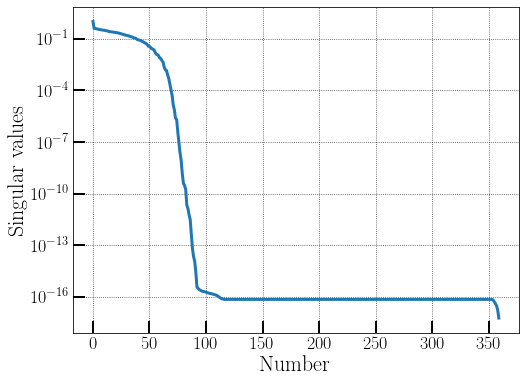

In [6]:
u, s, vh = svd(Fisher)
plt.plot(s / max(s))
# plt.xscale('log')
plt.yscale('log')
plt.ylabel('Singular values')
plt.xlabel('Number')
plt.show()

In [7]:
InvFisher = pinv(Fisher, 1e-1)
s_recovered_pinv = np.dot(InvFisher, np.dot(R_matrix.T.conj(),y_vector))

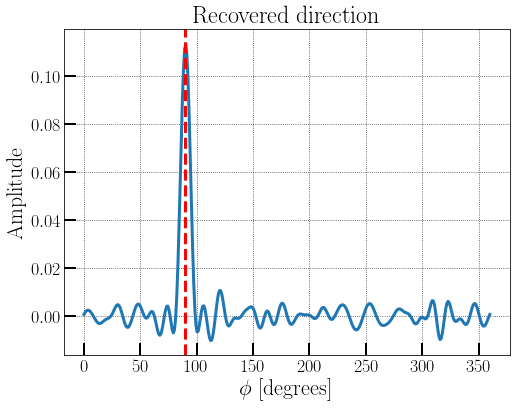

In [8]:
plt.title('Recovered direction')
plt.plot(np.degrees(phi_search_array), np.real(s_recovered_pinv))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

In [9]:
print('Recovered amplitude of wave is: %4.2f' % np.sum(np.real(s_recovered_pinv)))
print('Injected amplitude of wave was: %4.2f' % amplitude)

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.
Recovered amplitude of wave is: 1.01
Injected amplitude of wave was: 1.00


## Examining loss

We can examine the **point spread function** of this by noting that $F^+ F \neq \mathbb{I}$ where $F^+$ is the pseudo-inverse of the Fisher matrix, $F$ (given above as $\bf{R}^\dagger\bf{R}$). This is also known as the "model resolution matrix." Essentially, if we have some $\bf{s}_{\rm true}$, then it is related to $\bf{s}_{\rm recovered}$ by this model resolution matrix. Simple algebra will show that

$$\bf{s}_{\rm recovered} = (\bf{F}^+ \bf{F})\; \bf{s}_{\rm true}.$$

Below, we look at how a true signal gets spread into multiple azimuthal bins due to the fact that we can't properly invert the Fisher matrix.

Taking a column of the model resolution matrix 
$$\bf{M} = (\bf{F}^+ \bf{F})$$ shows us what this looks like

/tmp/ipykernel_4066454/3768069707.py:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(np.degrees(phi_search_array), np.degrees(phi_search_array),


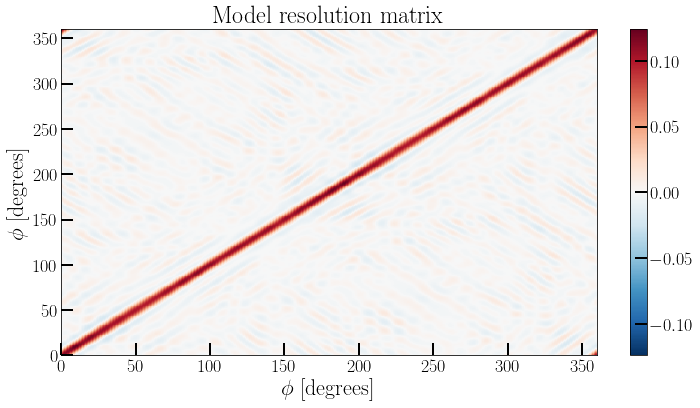

In [10]:
plt.figure(figsize=(12,6))
MRM = np.real(np.dot(InvFisher, Fisher))
plt.pcolormesh(np.degrees(phi_search_array), np.degrees(phi_search_array),
               MRM, vmin=-np.max(np.abs(MRM.flatten())), vmax=np.max(np.abs(MRM.flatten())), cmap='RdBu_r')
plt.colorbar()
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('$\phi$ [degrees]')
plt.title('Model resolution matrix')
plt.show()

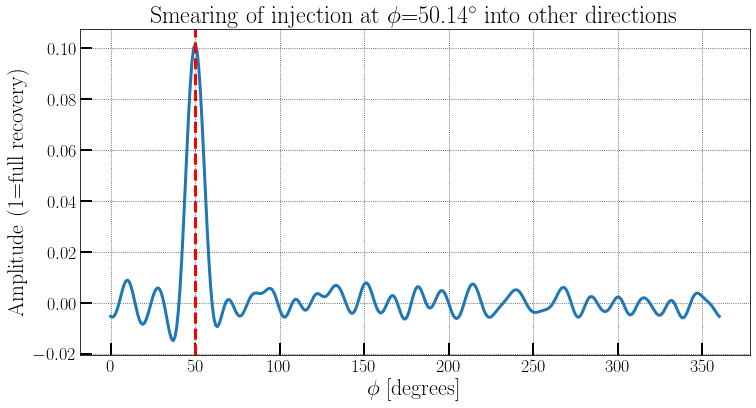

In [11]:
plt.figure(figsize=(12,6))
plt.title('Smearing of injection at $\phi$=%4.2f$^\circ$ into other directions' % np.degrees(phi_search_array[50]))
plt.plot(np.degrees(phi_search_array), MRM[:, 50])
ax = plt.gca()
ax.axvline(np.degrees(phi_search_array[50]), c='r', ls='--')
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude (1=full recovery)')
plt.show()

# Least squares solvers

A different way to solve this is to solve the least-squares problem where we find $\bf{s}$ such that

$$ || \bf{Y} - \bf{Rs}||_2$$

is minimized.

We can do this with a damping term to take the form of the regularization. We do this using the `scipy.sparse.linalg.lsqr` function. There are plenty of other linear solvers. In the end, with a damping term this is basically *exactly* the same as the above method.

In [12]:
result = lsqr(Fisher, np.dot(R_matrix.T.conj(), y_vector), damp=1000)
s_recovered_lsqr = np.real(result[0])

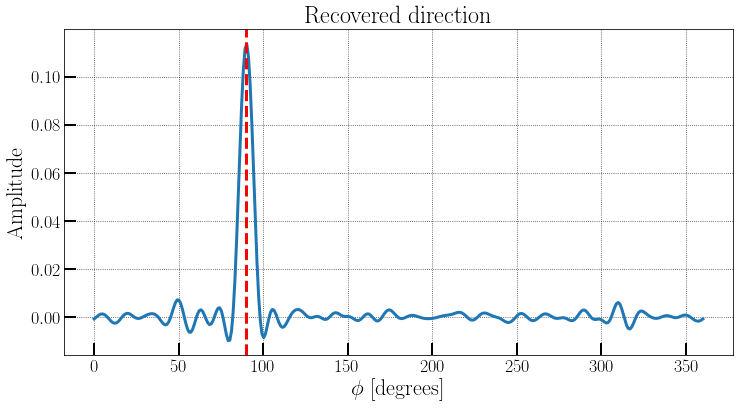

In [13]:
plt.figure(figsize=(12,6))
plt.title('Recovered direction')
plt.plot(np.degrees(phi_search_array), np.real(s_recovered_lsqr))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

In [14]:
print('Recovered amplitude of wave is: %4.2f' % np.sum(np.real(s_recovered_lsqr)))
print('Injected amplitude of wave was: %4.2f' % amplitude)

Recovered amplitude of wave is: 1.00
Injected amplitude of wave was: 1.00


# A problem!

It's important to note now that there's a fundamental issue here -- we're allowing for negative solutions to a value $||s(\phi)||^2$ that is inherently positive. There are a few ways we can deal with this. Since we just discussed linear solvers we'll start with one along those lines called "NNLS," which is short for "Non-negative least squares."

## NNLS

In this case, we add a constraint requiring all elements of the vector $\bf{s}$ to be positive. The **NNLS** algorithm is discussed well on wikipedia and is given in more detail in the book "Least squares problems" by Lawson and Hanson.

Thankfully, there is a scipy version of this. This method is known as an "active set" method. In this case, it only works for real inputs. Therefore we have re-framed the problem in terms of

$$ \bf{R^\dagger Y} = \bf{R^{\dagger} R}\,\bf{s}, $$, having mulitplied our initial problem by $\bf{R}^\dagger$. This applies the appropriate phase we want, and so we can safely say that both sides should be real and we should still get the right solution.

## Discussion of plots below

We see in the plots below that by adding the non-negative contraint we have recovered the correct direciton almost exactly. In fact, if we increase the number of points by 10 that we sample for $\phi$...we still only get a couple of pixels out. Do we **actually** get arbitrary resolution out this way?

In the next section we discuss another method that samples the likelihood at every point. In some sense, the NNLS is, **I think** a quick way of doing the same thing.

In [15]:
result = nnls(np.real(Fisher), np.real(np.dot(R_matrix.T.conj(), y_vector)))
s_recovered_nnls = result[0]

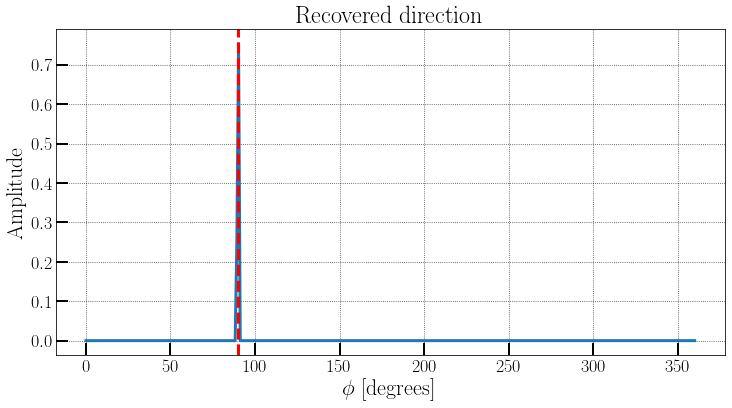

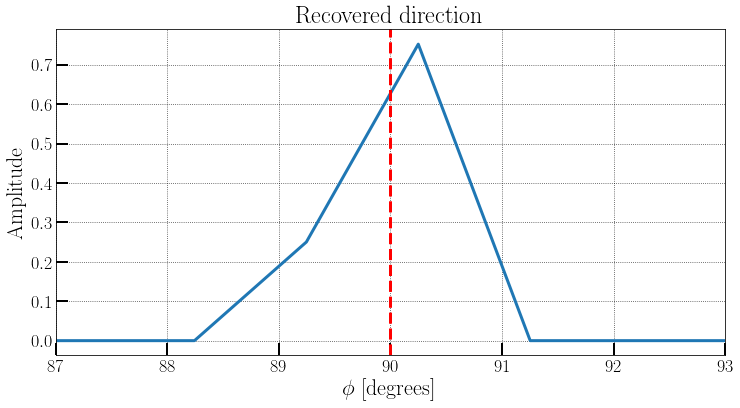

In [16]:
plt.figure(figsize=(12,6))
plt.title('Recovered direction')
plt.plot(np.degrees(phi_search_array), np.real(s_recovered_nnls))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(12,6))
plt.title('Recovered direction')
plt.plot(np.degrees(phi_search_array), np.real(s_recovered_nnls))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlim(np.degrees(phi)-3, np.degrees(phi)+3)
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

In [17]:
print('Recovered amplitude of wave is: %4.2f' % np.sum(np.real(s_recovered_nnls)))
print('Injected amplitude of wave was: %4.2f' % amplitude)

Recovered amplitude of wave is: 1.00
Injected amplitude of wave was: 1.00


# MCMC methods

We can also make the assumption that there is a single plane-wave and try to recover its direction and amplitude by guessing it and evaluating our Gaussian likelihood directly. We'll try this below using a nested sampling algorithm from the sampler `dynesty`.

Here, we see that we get essentially whatever resolution we want out...similar in some sense to the nnls method.

It's still not immediatley clear to me why this is the case.

In [18]:
def construct_r_single_phi(locations, c, freq, phi):
    phi_cartesian = np.array([cos(phi), sin(phi)])
    Nsensors = locations.shape[0]
    Npairs = int((Nsensors**2 + Nsensors)/2)
    R_matrix = np.zeros(Npairs, dtype='complex')
    counter = 0
    for ii in range(Nsensors):
        for jj in range(ii, Nsensors):
            # construct R matrix
            diff_vector = locations[ii, :] - locations[jj, :]
            R_matrix[counter] = np.exp(2 * np.pi * 1j * freq * np.dot(diff_vector, phi_cartesian) / c)
            counter += 1
    return R_matrix

from scipy.interpolate import interp2d
print(R_matrix.shape)
myfunc_real = interp2d(np.arange(Npairs), phi_search_array, R_matrix.T.real)
myfunc_imag = interp2d(np.arange(Npairs), phi_search_array, R_matrix.T.imag)
def loglike(x):
    A, phi = x
    myvec = y_vector - A * (myfunc_real(np.arange(Npairs), phi) + 1j*myfunc_imag(np.arange(Npairs), phi))
    return -0.5 * np.sum(np.abs(np.dot(myvec.T.conj(), myvec))) / 1e-6
def prior(x):
    x[0] *= 2
    x[1] *= 2*np.pi
    return x

(465, 360)


In [19]:
%%timeit
loglike([1,0])

212 µs ± 37.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
from dynesty import NestedSampler, DynamicNestedSampler

In [21]:
sampler = DynamicNestedSampler(loglike, prior, 2, nlive=50)
sampler.run_nested()

29733it [05:08, 96.49it/s, batch: 12 | bound: 77 | nc: 1 | ncall: 68659 | eff(%): 43.305 | loglstar: -7369.472 < -7364.050 < -7364.411 | logz: -7387.185 +/-  0.297 | stop:  0.990]            


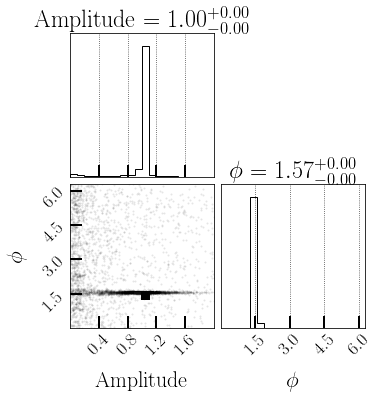

In [22]:
from corner import corner
corner(sampler.results.samples, labels=['Amplitude', '$\phi$'], show_titles=True)
plt.show()

In [23]:
from dynesty import utils as dyfunc
results = sampler.results
samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [24]:
new_samples = dyfunc.resample_equal(samples, weights)

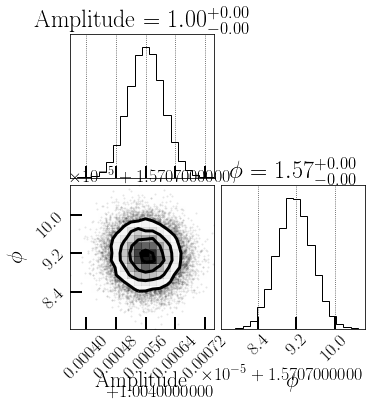

In [25]:
from corner import corner
corner(new_samples, labels=['Amplitude', '$\phi$'], show_titles=True)
plt.show()

# Explore limits of NNLS method

Now that the MCMC has given us some estimate of the standard deviation where we are directly sampling the likelihood, let's see of NNLS gives us something similar by zooming in.

It seems that we're still picking out **exactly** the correct direction, no matter how far I zoom in. I'm not sure if this has anything to do with the fact that we're essentially giving it a prior around a specific value. but that would not change things in the MCMC case...as we'd still give it a uniform prior and the error would probably be determined by the uncertainty.

It's useful to note that I havne't added any noise in here at all...maybe I'll have to try that next.

In [26]:
unc_mcmc = 7.8e-5 - 5.4e-5
print(unc_mcmc)
phi_range = 0.0001
Nphis = 2 * phi_range / (unc_mcmc / 50)
print(Nphis)
new_phis = np.linspace(phi - phi_range, phi+phi_range, num=int(Nphis))
print(new_phis.size)
new_phis_cartesian = np.vstack((np.cos(new_phis), np.sin(new_phis)))

2.4e-05
416.66666666666663
416


In [27]:
print(new_phis_cartesian.shape)
R_matrix_new = np.zeros((Npairs, new_phis.size), dtype='complex')
print(R_matrix_new.shape)
counter = 0
for ii in range(Nsensors):
    for jj in range(ii, Nsensors):
        # construct R matrix
        diff_vector = locations[ii, :] - locations[jj, :]
        R_matrix_new[counter, :] = np.exp(2 * np.pi * 1j * freq * np.dot(diff_vector, new_phis_cartesian) / c)
        counter += 1

(2, 416)
(465, 416)


In [28]:
Fisher_new = np.dot(R_matrix_new.T.conj(),R_matrix_new)
result_new = nnls(np.real(Fisher_new), np.real(np.dot(R_matrix_new.T.conj(), y_vector)))
s_recovered_nnls_new = result_new[0]

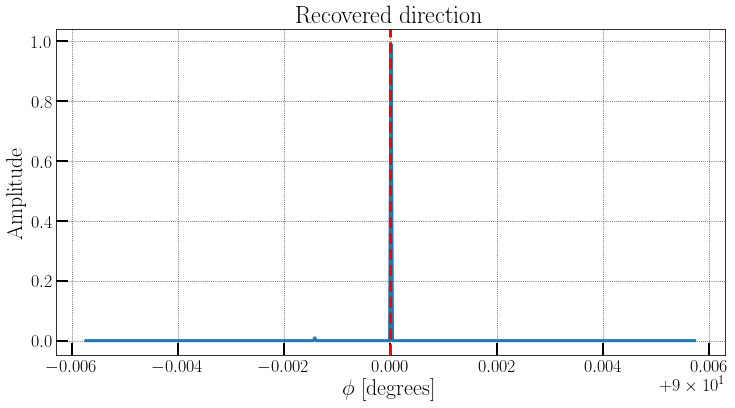

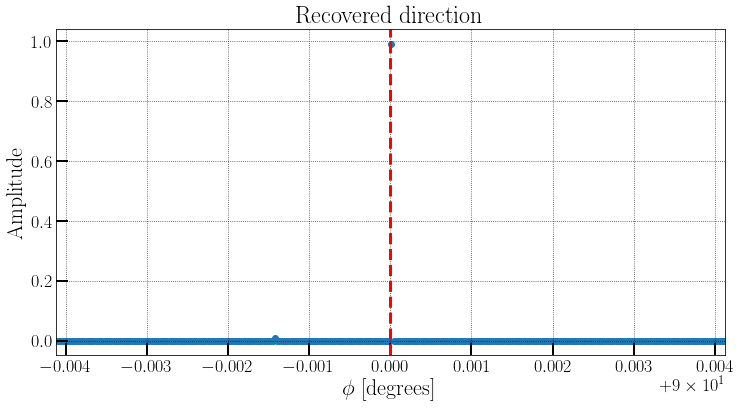

In [29]:
plt.figure(figsize=(12,6))
plt.title('Recovered direction')
plt.plot(np.degrees(new_phis), np.real(s_recovered_nnls_new))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

plt.figure(figsize=(12,6))
plt.title('Recovered direction')
plt.scatter(np.degrees(new_phis), np.real(s_recovered_nnls_new))
ax = plt.gca()
ax.axvline(np.degrees(phi), ls='--', c='r')
plt.xlim(np.degrees(phi-3*unc_mcmc), np.degrees(phi+3*unc_mcmc))
plt.xlabel('$\phi$ [degrees]')
plt.ylabel('Amplitude')
plt.show()

In [30]:
new_phis[2] - new_phis[1]

4.819277108492059e-07

In [31]:
print(s_recovered_nnls_new[s_recovered_nnls_new>0])

[0.00961539 0.99038461]
